## This model version is used to train data from a glyphosate using data from the Hammamatsu spec sensor.
### Input data = 100 (50 dispersion + 50 emission)

In [ ]:
# Import modules
import os

# --- Step 1: Force CPU Usage (MUST be first) ---
# This ensures deterministic computations by avoiding the MPS GPU backend.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import numpy as np
import random

# --- Step 2: Set All Random Seeds ---
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

print("Forcing CPU-only execution for reproducibility. ✅")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.callbacks import EarlyStopping

import csv
# Misc
# from itertools import islice
# import plotly.express as px

Forcing CPU-only execution for reproducibility. ✅
Num GPUs Available:  0


### Read main file with samples

In [16]:
# Create augmentations with original data

# File path with measurements 
file_path = 'sep17v2.csv'

# Open file with data. Extract first 19 elements in each row
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    data = []
    for i,row in enumerate(reader):
        #data.append(row)
        if n<28:
            data.append(row)
        n+=1
len(data)

28

### Read second file with samples

In [17]:
# File path with measurements 
file_path = 'tarev1.csv'

# Open file with data. Extract first 19 elements in each row
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    data_2 = []
    for i,row in enumerate(reader):
        #data_2.append(row)
        if n<10:
            data_2.append(row)
        n+=1
len(data_2)
# must take 10 samples # column index 53 contains '-'

10

### Review structure

In [ ]:
import matplotlib.pyplot as plt
#print(len(data),len(data[0]))
y_data = []
for i,y_i in enumerate(data): 
    y_row = []
    #print(len(y_i))
    for j in y_i[3:]:
        #print(j)
        if j != '-':
            y_row.append(float(j))
    y_data.append(y_row)
    
#print(len(y_data[0]))
x_data = np.linspace(400,950,len(y_data[0]))
#print(len(x_data))

plt.figure(figsize=(10, 10))
prev_cc = y_data[0][1]
b_color = 0.0
r_color = 1.0
for i in range(len(data)):
    cc = data[i][1]
    curr_cc = y_data[i][1]
    if prev_cc != curr_cc:
        b_color = 0.0 + (i/len(data))
        r_color = 1.0 - (i/len(data))
    plt.plot(x_data,y_data[i], label='Sample Data: '+ str(cc), color=(r_color,0.6,b_color))
    prev_cc = curr_cc
plt.xlabel('Band?')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

### Augmentations for main file

In [25]:
# Create augmentations with original data

# File path with measurements 
file_path = 'sep17v2.csv'

# Create list variables
nombres = []
invalues = []
outvalues = []

# Create list for augmentations
filaau = ["A"] * 110
aug = []

variants = 15
# Open file with data. Extract first 19 elements in each row
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    for row in reader:
        if n<28:
            filaau[1]=row[1] # row[1] is glyphosate concentration (true)
        # Start augmentations 
            # +-X% noise augmentation (3 variants per sample)
            for j in range(1,variants):
              filaau[0]=row[0]+"_"+ str(j) # filaau contains string name sample + j-index (20 j-indices per row/sample).

              # first block of x data
              for i in range(3,53): # Iterate over column 3 to 53 in csv per j iteration (20 j-indices)
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(0.95, 1.05)
                # back2string
                #filaau[i]=str(int(filaau[i]))
              
              filaau[53]='-'

              # second block of x data
              for i in range(54,104):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(0.95, 1.05)
                # back2string
                #filaau[i]=str(int(filaau[i]))

              # Save augmentation
              aug.append(filaau.copy())

            #+-X noise augmentations%
            for j in range(variants,variants*2):

              filaau[0]=row[0]+"_"+ str(j)

              for i in range(3,53):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(0.98, 1.02)
                #filaau[i]=str(int(filaau[i]))
                
              filaau[53]='-'

              for i in range(54,104):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(0.98, 1.02)
                #filaau[i]=str(int(filaau[i]))

              aug.append(filaau.copy())


            #+/- 10% AUGMENTATIONS not used

            # for j in range(41,61): # this range seems to be wrong. Should be 41,61

            #   filaau[0]=row[0]+"_"+ str(j)

              
            #   multi2=random.uniform(0.1, 1)
            #   for i in range(3,53):
            #     filaau[i]=float(row[i])
            #     filaau[i]=int(filaau[i])
            #     #Hacer modificacion de valor
            #     filaau[i]=filaau[i]+(random.uniform(0.1, 1)*50)
            #     #Regresar a String
            #     filaau[i]=str(int(filaau[i]))

            #   for i in range(54,104):
            #     filaau[i]=float(row[i])
            #     filaau[i]=int(filaau[i])
            #     #Hacer modificacion de valor
            #     filaau[i]=filaau[i]+(random.uniform(0.1, 1)*50)
            #     #Regresar a String
            #     filaau[i]=str(int(filaau[i]))

            #   #Guarda aumentacion
            #   aumentaciones.append(filaau.copy())
        n+=1

# Create CSV file with augmentations
# csv_file_path = 'augmentationsV0.csv'

# Writing to CSV file
# with open(csv_file_path, 'w', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file)
#     # Writing the data to the CSV file
#     csv_writer.writerows(aug)
len(data),len(aug)

(28, 812)

### Augmentations for second file

In [26]:
# Create augmentations with original data

# File path with measurements 
file_path = 'tarev1.csv'

# Create list variables
nombres = []
invalues = []
outvalues = []

# Create list for augmentations
filaau = ["A"] * 110
#aug = []

variants = 15
# Open file with data. Extract first 19 elements in each row
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    for row in reader:
        if n<10:
            filaau[1]=row[1] # row[1] is glyphosate concentration (true)
        # Start augmentations 
            # +-X% noise augmentation (3 variants per sample)
            for j in range(1,variants):
              filaau[0]=row[0]+"_"+ str(j) # filaau contains string name sample + j-index (20 j-indices per row/sample).

              # first block of x data
              for i in range(3,53): # Iterate over column 3 to 53 in csv per j iteration (20 j-indices)
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(0.95, 1.05)
                # back2string
                #filaau[i]=str(int(filaau[i]))
              
              filaau[53]='-'

              # second block of x data
              for i in range(54,104):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(0.95, 1.05)
                # back2string
                #filaau[i]=str(int(filaau[i]))

              # Save augmentation
              aug.append(filaau.copy())

            #+-X noise augmentations%
            for j in range(variants,variants*2):

              filaau[0]=row[0]+"_"+ str(j)

              for i in range(3,53):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(0.98, 1.02)
                #filaau[i]=str(int(filaau[i]))
                
              filaau[53]='-'

              for i in range(54,104):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(0.98, 1.02)
                #filaau[i]=str(int(filaau[i]))

              aug.append(filaau.copy())


            #+/- 10% AUGMENTATIONS not used

            # for j in range(41,61): # this range seems to be wrong. Should be 41,61

            #   filaau[0]=row[0]+"_"+ str(j)

              
            #   multi2=random.uniform(0.1, 1)
            #   for i in range(3,53):
            #     filaau[i]=float(row[i])
            #     filaau[i]=int(filaau[i])
            #     #Hacer modificacion de valor
            #     filaau[i]=filaau[i]+(random.uniform(0.1, 1)*50)
            #     #Regresar a String
            #     filaau[i]=str(int(filaau[i]))

            #   for i in range(54,104):
            #     filaau[i]=float(row[i])
            #     filaau[i]=int(filaau[i])
            #     #Hacer modificacion de valor
            #     filaau[i]=filaau[i]+(random.uniform(0.1, 1)*50)
            #     #Regresar a String
            #     filaau[i]=str(int(filaau[i]))

            #   #Guarda aumentacion
            #   aumentaciones.append(filaau.copy())
        n+=1

# Create CSV file with augmentations
# csv_file_path = 'augmentationsV0.csv'

# Writing to CSV file
# with open(csv_file_path, 'w', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file)
#     # Writing the data to the CSV file
#     csv_writer.writerows(aug)
len(data),len(aug)

(28, 1102)

In [19]:
len(data_2)

10

In [ ]:
# Grafica un ejemplo de las aumentaciones
# en este arreglo se guardan los datos de las aumentaciones

import matplotlib.pyplot as plt

numdado=35
ploteaesto=[0] * 50

j=0
for i in range(3,53):
  ploteaesto[j]=float(aug[numdado][i])
  j=j+1


#j=50
#for i in range(54,104):
#  ploteaesto[j]=float(aumentaciones[numdado][i])
#  j=j+1


# Step 2: Plot the values
plt.figure(figsize=(10, 6))
plt.plot(ploteaesto, label='Sample Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of 100 Values')
plt.legend()
plt.grid(True)
plt.show()

## X and y data

In [34]:
# X and y data lists
_inputs = []
_targets = []

# Read csv file with augmentations; dispersion data
# with open(file_path, 'r') as file:
#     reader = csv.reader(file)

#     for row in reader:

#         name=row[0]
#         # Convert first 50 values to float
#         inputs = [float(val) for val in row[3:53]]
#         #row_values2= [float(val) for val in row[54:104]]
#         targets = [float(val) for val in row[1:2]]
#         #invalues.append(row_values1 + row_values2)
#         _inputs.append(inputs)
#         _targets.append(targets)
#         _tags.append(name)

# Add first block of data (original)
for i in range(len(data)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                        row_data.append(float(data[i][j]))
        _inputs.append(row_data)
        _targets.append(float(data[i][1]))

# # Add first block of data (augmentations)
# for i in range(len(aug)):
#         row_data = []
#         for j in range(3,104):
#                 if j!= 53:
#                         row_data.append(float(aug[i][j]))
#         _inputs.append(row_data)
#         _targets.append(float(aug[i][1]))

# Add third block of data (second file)
for i in range(len(data_2)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                        row_data.append(float(data_2[i][j]))
        _inputs.append(row_data)
        _targets.append(float(data_2[i][1]))

# Add second block of data (augmentations for main and second file)
for i in range(len(aug)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                        row_data.append(float(aug[i][j]))
        _inputs.append(row_data)
        _targets.append(float(aug[i][1]))

# Convert list to arrays
X_data = np.array(_inputs)
y_data= np.array(_targets)

print(len(X_data), len(y_data))
print(len(X_data[0]))

1140 1140
100


### Data normalization

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_data)

## New training code

In [35]:
import time

# 1. Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)

# Model definition
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(len(X_data[0]),)),
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              #loss='mean_absolute_error',
              metrics=['mae'])

# Model training
history = model.fit(
    X_train,
    y_train,
    epochs=20, # original 10
    batch_size=32,
    validation_data=(X_val, y_val), # Pass validation data here
    verbose=1
)

# Get the last validation loss from the training history
final_val_loss = history.history['val_loss'][-1]

# Get the current date and time
timestamp = time.strftime("%Y%m%d-%H%M%S")

# Create a descriptive filename using an f-string
dynamic_filename = f"model_loss-{final_val_loss:.4f}_{timestamp}.keras"

# Save the model with the new dynamic name
model.save('models/'+dynamic_filename)

# Print the name to see what was saved
print(f"Model saved successfully as: {dynamic_filename}")

Epoch 1/20


/opt/miniconda3/envs/gly_models/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 205487.6719 - mae: 284.1691 - val_loss: 33154.2734 - val_mae: 125.5394
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27191.3828 - mae: 116.0026 - val_loss: 22158.4453 - val_mae: 102.9371
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19170.4570 - mae: 94.1288 - val_loss: 17223.1367 - val_mae: 84.5992
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14215.7285 - mae: 75.6021 - val_loss: 12485.4912 - val_mae: 70.2731
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9846.0771 - mae: 61.4151 - val_loss: 8638.3672 - val_mae: 58.6917
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6451.7896 - mae: 49.7135 - val_loss: 5629.1519 - val_mae: 48.2478
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3989.5625 - mae: 41.0623 - val_loss: 3511.1521 - val_mae: 39.1627
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2516.5139 - mae: 34.0464 - val_loss: 2338.8943 - val_mae: 33.8265
Epoch 

## Inference

In [ ]:
# File path with measurements 
file_path = 'sep17v2.csv'

# Open file with data. 
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    test_data = []
    for i,row in enumerate(reader):
        #data.append(row)
        if n>=28:
            test_data.append(row)
        n+=1

_test_inputs = []
_test_targets = []

# Add first block of data (original)
for i in range(len(test_data)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                        row_data.append(float(test_data[i][j]))
        _test_inputs.append(row_data)
        _test_targets.append(float(test_data[i][1]))


# File path with measurements (second file) 
file_path = 'tarev1.csv'

# Open file with data. 
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    test_data = []
    for i,row in enumerate(reader):
        #data.append(row)
        if n>=10:
            test_data.append(row)
        n+=1

# Add second block of data (second file)
for i in range(len(test_data)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                        row_data.append(float(test_data[i][j]))
        _test_inputs.append(row_data)
        _test_targets.append(float(test_data[i][1]))

# Convert list to arrays
X_test = np.array(_test_inputs)
y_test= np.array(_test_targets)

print(len(X_test), len(y_test))
print(len(X_test[0]))

X_test_scaled = scaler.transform(X_test)  # Note: just .transform(), not .fit_transform()
# X_test_pca = pca.transform(X_test_scaled)    # Note: just .transform(), not .fit_transform()

38 38
100


## Evaluate test results

Loading model from: model_loss-138.5615_20251007-175526.keras
Model loaded successfully.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Mean Absolute Error (MAE): 62.687
Root Mean Squared Error (RMSE): 84.038
R-squared (R2): 0.982


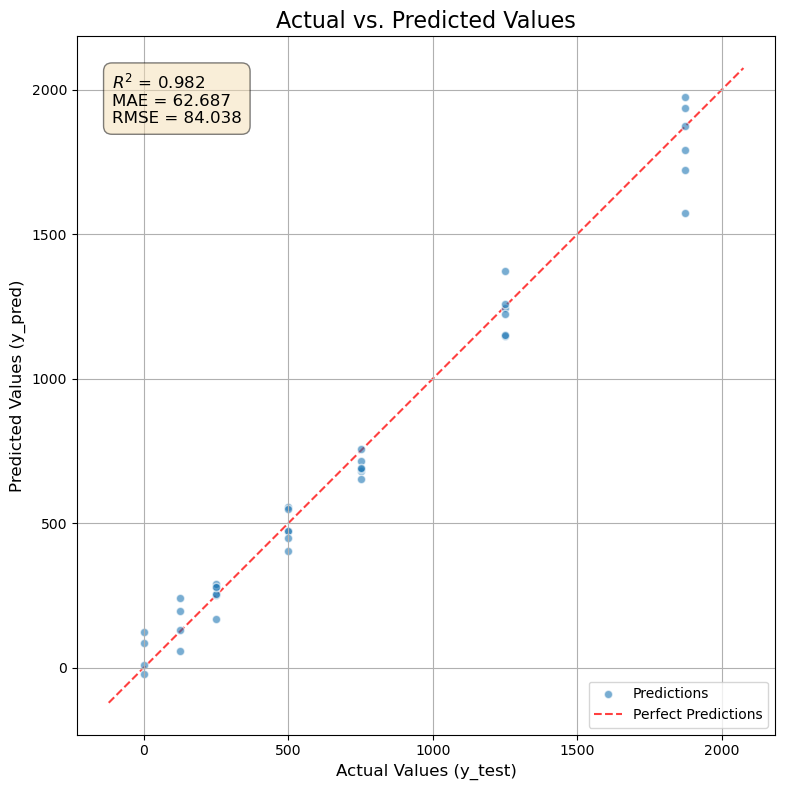

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assume 'dynamic_filename' is the variable holding your model's file name
# For example: dynamic_filename = 'model_loss-0.1234_20251006-233414.keras'

# Load the saved model from the file
print(f"Loading model from: {dynamic_filename}")
loaded_model = tf.keras.models.load_model('models/'+dynamic_filename)
print("Model loaded successfully.")

X_test = X_test_scaled
# Use the loaded model to make predictions on the test data
y_pred = loaded_model.predict(X_test)

# The output of .predict() is often a 2D array, so we flatten it to a 1D array
# to make it easy to compare with y_test
y_pred = y_pred.flatten()

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R2): {r2:.3f}")

# 2. Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot of actual vs. predicted values
ax.scatter(y_test, y_pred, alpha=0.6, edgecolors="w", label='Predictions')

# Add a line for perfect predictions (y=x)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Predictions')

# 3. Add metrics to the plot
# Using LaTeX for R^2
metrics_text = (
    f"$R^2$ = {r2:.3f}\n"
    f"MAE = {mae:.3f}\n"
    f"RMSE = {rmse:.3f}"
)
# Place text box in the top-left corner
ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

# 4. Final plot settings
ax.set_xlabel("Actual Values (y_test)", fontsize=12)
ax.set_ylabel("Predicted Values (y_pred)", fontsize=12)
ax.set_title("Actual vs. Predicted Values", fontsize=16)
ax.set_aspect('equal', adjustable='box')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#!pip install everywhereml>=0.2.12


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\algim\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [23]:
from everywhereml.code_generators.tensorflow import tf_porter

#tf_model, x_train, y_train = get_model()
# tf_porter() requires:
#   1. the neural network model
#   2. the input data (to detect the input dimensions)
#   3. the output labels (to detect the number of classes - if classification)
#
# Passing `instance_name` will create an instance of the model, so you don't have to
# `area_size` is to control how much memory to allocate for the network
# It is a trial-and-error process


#porter = tf_porter(tf_model, entradas_train, salidas_train)
porter = tf_porter(model, entradas_train, salidas_train)
cpp_code = porter.to_cpp(instance_name='glifoNN1', arena_size=10000)

#cpp_code.save('/content/gdrive/My Drive/NNglifosato2/NNmar19')

print(cpp_code)

INFO:tensorflow:Assets written to: C:\Users\algim\AppData\Local\Temp\tmpkmj07hdr\assets


INFO:tensorflow:Assets written to: C:\Users\algim\AppData\Local\Temp\tmpkmj07hdr\assets


#ifndef UUID2187630171792
#define UUID2187630171792

#include <EloquentTinyML.h>
#include <eloquent_tinyml/tensorflow.h>

#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

#ifndef ARENA_SIZE
#define ARENA_SIZE 10000
#endif

/** model size = 34128 bytes **/
const unsigned char modelData[] DATA_ALIGN_ATTRIBUTE = { 0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x94, 0x00, 0x00, 0x00, 0xec, 0x00, 0x00, 0x00, 0x6c, 0x7e, 0x00, 0x00, 0x7c, 0x7e, 0x00, 0x00, 0xfc, 0x84, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00, 0x10, 0x00, 0x0c, 0x0